# Week3: 대학별 학자금 대출 불균형 위험 분류 (Baseline)

### 문제 정의
- 목적: 대학의 대출 구조 불균형(Gini_금액)이 `상위 20%`인지 여부를 분류(위험군=1)

- 근거: 특정 대출 유형(등록금/생활비, 일반/취업후상환)에 편중될수록 학생 재무건전성 위험 ↑

### 데이터
- Notebook A에서 전처리/피처 엔지니어링을 끝낸 `week3_dataset_final.csv`

- 주요 변수: 평균등록금, 대출자비율_일반, 1인당 평균대출액, 재학생수, Gini_금액, 연도 등

### 모델링 계획
- 분류 모델 3종(Baseline): Logistic Regression / Decision Tree / Random Forest

- (옵션) XGBoost: 설치 시 자동 실행

- 평가: Classification Report(정확도/정밀도/재현율/F1), ROC Curve & AUC, Feature Importance, 로지스틱 계수

### 해석 포인트
- 위험군을 놓치면 비용이 큰 문제 → `재현율(Recall)`과 `ROC-AUC`에 주목

- 중요 변수 상위 → 위험군 형성에 기여하는 요인 해석

----

### 1. 라이브러리 & 설정

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 (Windows)
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)

### 2. 데이터 불러오기

In [4]:
CSV_PATH = r"C:\Users\jso25\OneDrive\Desktop\EPOCH\pilot\data\week3_dataset_final.csv"

# 인코딩 자동 처리
try:
    df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
except UnicodeDecodeError:
    df = pd.read_csv(CSV_PATH, encoding="cp949")

print("[불러오기 완료] df.shape =", df.shape)


[불러오기 완료] df.shape = (1260, 32)


### 3. 타깃 생성: 연도별 Gini 상위 20% → 위험군

- 분류 타깃은 연도별 `Gini_금액` 상위 20%를 위험군(1)으로 설정.

- 연도별로 상위/하위 분포가 다를 수 있으므로 `연도 기준`으로 상위 20%를 나눈다.

#### 3-1. 타깃 생성 코드

In [5]:
def make_yearwise_top20_risk(dd, score_col="Gini_금액", year_col="연도", out_col="위험군"):
    assert score_col in dd.columns, f"'{score_col}'가 필요합니다."
    dd = dd.copy()
    dd[out_col] = 0
    if year_col in dd.columns:
        for yr, g in dd.groupby(year_col):
            thr = g[score_col].quantile(0.80)
            dd.loc[g.index[g[score_col] >= thr], out_col] = 1
    else:
        thr = dd[score_col].quantile(0.80)
        dd[out_col] = (dd[score_col] >= thr).astype(int)
    return dd

df = make_yearwise_top20_risk(df, score_col="Gini_금액", year_col="연도", out_col="위험군")
print("[타깃 생성] 위험군 비율 =", df["위험군"].mean().round(3))
df["위험군"].value_counts(normalize=True)


[타깃 생성] 위험군 비율 = 0.201


위험군
0    0.799206
1    0.200794
Name: proportion, dtype: float64

### 4. 특징 변수 매핑/생성

- 파일마다 컬럼명이 약간 다를 수 있어 유연하게 탐색:

  - 평균등록금: '평균등록금(원)' 또는 '평균등록금'

  - 1인당 평균대출액: '평균대출금액' 또는 '1인당평균대출액'

  - 없으면 (일반+취업) 총금액 / (일반+취업) 총학생수로 생성

  - 필수: '대출자비율_일반', '재학생수'


### 4.1 매핑

In [6]:
cols = list(df.columns)

def find_first_includes(keywords):
    for kw in keywords:
        m = [c for c in cols if kw in str(c)]
        if m:
            return m[0]
    return None

# 평균등록금
tuition_col = find_first_includes(["평균등록금(원)", "평균등록금"])
if tuition_col is None:
    raise KeyError("평균등록금 컬럼을 찾지 못했습니다. (예: '평균등록금(원)' 또는 '평균등록금')")

# 1인당 평균대출액
avgloan_col = find_first_includes(["평균대출금액", "1인당평균대출액"])
if avgloan_col is None:
    need_amt = {"일반학자금대출_전체_금액","취업학자금대출_전체_금액"}
    need_cnt = {"일반학자금대출_전체_학생수","취업학자금대출_전체_학생수"}
    if need_amt.issubset(cols) and need_cnt.issubset(cols):
        total_amt = pd.to_numeric(df["일반학자금대출_전체_금액"], errors="coerce").fillna(0) + \
                    pd.to_numeric(df["취업학자금대출_전체_금액"], errors="coerce").fillna(0)
        total_cnt = pd.to_numeric(df["일반학자금대출_전체_학생수"], errors="coerce").fillna(0) + \
                    pd.to_numeric(df["취업학자금대출_전체_학생수"], errors="coerce").fillna(0)
        df["평균대출금액_auto"] = total_amt / total_cnt.replace(0, np.nan)
        avgloan_col = "평균대출금액_auto"
        print("➡ '평균대출금액_auto' 생성(일반+취업 총금액/총인원)")
    else:
        raise KeyError("1인당 평균대출액(=평균대출금액) 컬럼을 찾거나 만들 수 없습니다.")

# 필수 존재
for need in ["대출자비율_일반", "재학생수"]:
    if need not in df.columns:
        raise KeyError(f"'{need}' 컬럼이 없습니다. 전처리 단계 확인!")

FEATURES = [tuition_col, "대출자비율_일반", avgloan_col, "재학생수"]
FEATURES


➡ '평균대출금액_auto' 생성(일반+취업 총금액/총인원)


['평균등록금', '대출자비율_일반', '평균대출금액_auto', '재학생수']

### 5. 데이터셋 구성 & 분할

In [7]:
X = df[FEATURES].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(0)
y = df["위험군"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape, "| 양성비율(Train) =", y_train.mean().round(3))


Train: (1008, 4) Test: (252, 4) | 양성비율(Train) = 0.2


### 6. 모델 학습

- Logistic Regression: 해석 용이, 선형 관계 가정 → 베이스라인

- Decision Tree: 규칙 기반, 비선형/상호작용 포착

- Random Forest: 앙상블, 일반화 성능 우수(빠른 설정)

- XGBoost: 설치 시 자동 실행


In [8]:
# Logistic (스케일 필요)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)
logreg = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
logreg.fit(X_train_s, y_train)

# Decision Tree
tree = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced")
tree.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=150, max_depth=6, random_state=42, n_jobs=-1,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)

# (옵션) XGBoost
xgb_clf = None
try:
    import xgboost as xgb
    xgb_clf = xgb.XGBClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8,
        tree_method="hist", random_state=42, n_jobs=-1
    )
    xgb_clf.fit(X_train, y_train)
except Exception as e:
    print(f"[알림] XGBoost 건너뜀: {e}")
    xgb_clf = None

### 7. 모델 평가: 리포트 & 혼동행렬


=== Logistic Regression ===
              precision    recall  f1-score   support

           0      0.904     0.612     0.730       201
           1      0.328     0.745     0.455        51

    accuracy                          0.639       252
   macro avg      0.616     0.679     0.593       252
weighted avg      0.788     0.639     0.674       252



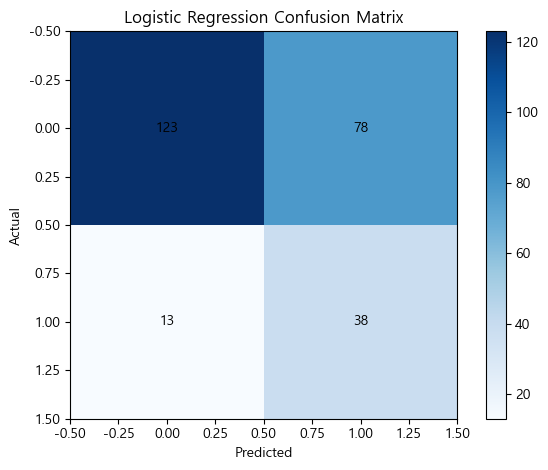


=== Decision Tree ===
              precision    recall  f1-score   support

           0      0.939     0.692     0.797       201
           1      0.404     0.824     0.542        51

    accuracy                          0.718       252
   macro avg      0.672     0.758     0.669       252
weighted avg      0.831     0.718     0.745       252



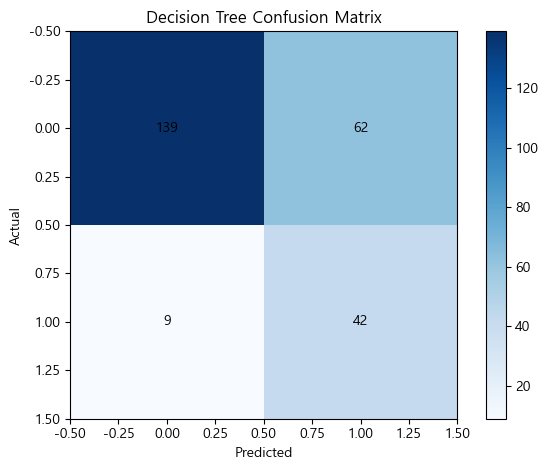


=== Random Forest ===
              precision    recall  f1-score   support

           0      0.932     0.751     0.832       201
           1      0.444     0.784     0.567        51

    accuracy                          0.758       252
   macro avg      0.688     0.768     0.700       252
weighted avg      0.833     0.758     0.778       252



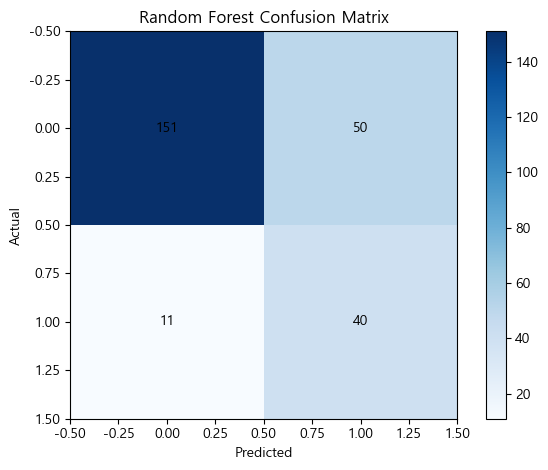


=== XGBoost ===
              precision    recall  f1-score   support

           0      0.869     0.861     0.865       201
           1      0.472     0.490     0.481        51

    accuracy                          0.786       252
   macro avg      0.671     0.675     0.673       252
weighted avg      0.789     0.786     0.787       252



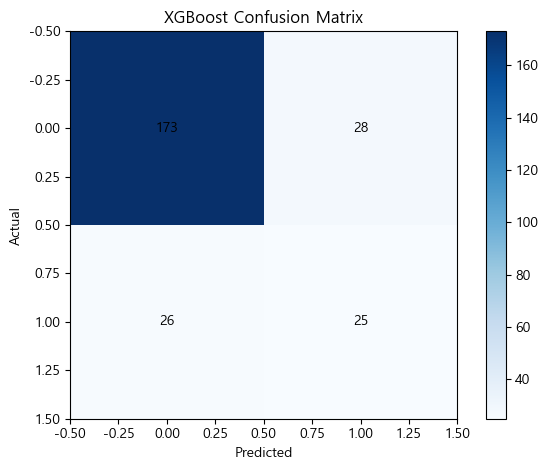

In [9]:
def print_report(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, digits=3))
    cm = confusion_matrix(y_true, y_pred)

    # 시각화 (matplotlib)
    plt.figure()
    plt.imshow(cm, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.colorbar(); plt.tight_layout(); plt.show()

pred_log  = logreg.predict(X_test_s)
pred_tree = tree.predict(X_test)
pred_rf   = rf.predict(X_test)

print_report("Logistic Regression", y_test, pred_log)
print_report("Decision Tree", y_test, pred_tree)
print_report("Random Forest", y_test, pred_rf)
if xgb_clf is not None:
    pred_xgb = xgb_clf.predict(X_test)
    print_report("XGBoost", y_test, pred_xgb)


### 8. ROC Curve & AUC

<Figure size 640x480 with 0 Axes>

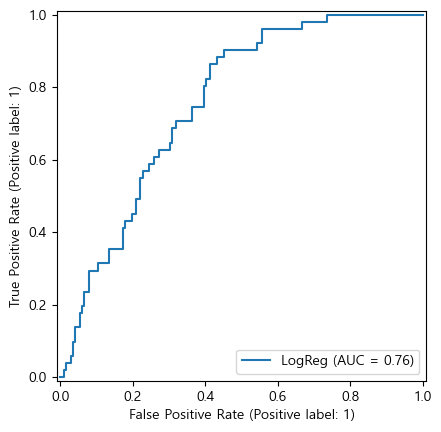

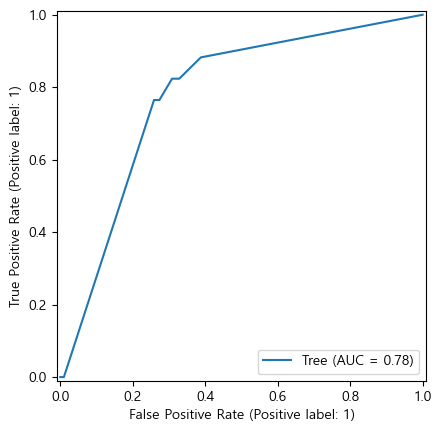

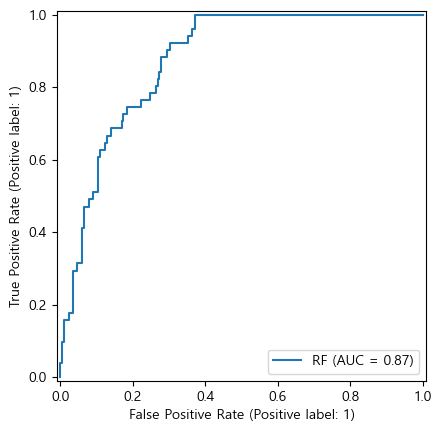

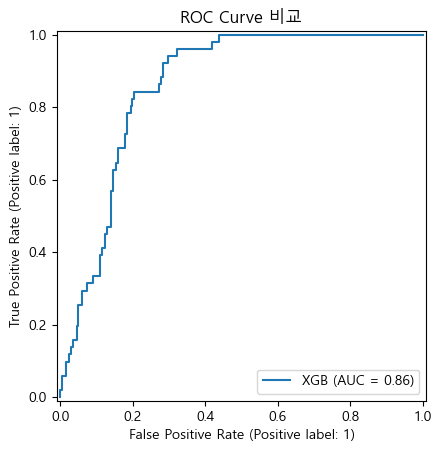


[ROC-AUC]
LogReg ROC-AUC: 0.756
Tree ROC-AUC: 0.777
RF ROC-AUC: 0.874
XGB ROC-AUC: 0.859


In [10]:
plt.figure()
RocCurveDisplay.from_estimator(logreg, X_test_s, y_test, name="LogReg")
RocCurveDisplay.from_estimator(tree,   X_test,   y_test, name="Tree")
RocCurveDisplay.from_estimator(rf,     X_test,   y_test, name="RF")
if xgb_clf is not None:
    RocCurveDisplay.from_estimator(xgb_clf, X_test, y_test, name="XGB")
plt.title("ROC Curve 비교")
plt.show()

def safe_auc(model, Xv, yv, name):
    try:
        p = model.predict_proba(Xv)[:,1]
        auc = roc_auc_score(yv, p)
        print(f"{name} ROC-AUC: {auc:.3f}")
        return auc
    except Exception:
        try:
            s = model.decision_function(Xv)
            auc = roc_auc_score(yv, s)
            print(f"{name} ROC-AUC(decision): {auc:.3f}")
            return auc
        except Exception as e:
            print(f"{name} AUC 계산 불가: {e}")
            return np.nan

print("\n[ROC-AUC]")
_ = safe_auc(logreg, X_test_s, y_test, "LogReg")
_ = safe_auc(tree,   X_test,   y_test, "Tree")
_ = safe_auc(rf,     X_test,   y_test, "RF")
if xgb_clf is not None:
    _ = safe_auc(xgb_clf, X_test, y_test, "XGB")


### 9. 모델 해석: 변수 중요도 & 계수

,importance
평균대출금액_auto,0.374714
대출자비율_일반,0.330908
평균등록금,0.192776
재학생수,0.101602


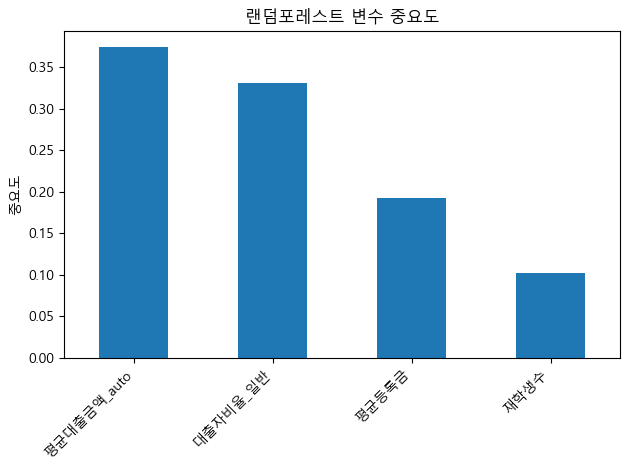


[Logistic Regression Coefficients] (+는 위험군 확률↑)


,feature,coef
0,평균등록금,0.951902
3,재학생수,0.268920
2,평균대출금액_auto,-0.352060
1,대출자비율_일반,-1.395455


In [11]:
# RandomForest Feature Importance
importances = pd.Series(rf.feature_importances_, index=FEATURES).sort_values(ascending=False)
display(importances.to_frame("importance"))

plt.figure()
importances.plot(kind="bar")
plt.title("랜덤포레스트 변수 중요도")
plt.ylabel("중요도")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

# Logistic 계수(표준화 스케일 기준)
coef_df = pd.DataFrame({"feature": FEATURES, "coef": logreg.coef_[0]}).sort_values("coef", ascending=False)
print("\n[Logistic Regression Coefficients] (+는 위험군 확률↑)")
display(coef_df)

### 10. 결과 해석

#### 결과 요약 & 해석

1) 성능 비교
- Random Forest가 전반적으로 가장 높은 ROC-AUC/정확도를 보였고 Logistic은 해석은 쉽지만 성능은 다소 낮았다.

2) 중요한 변수
- RF 중요도: 평균등록금 > 대출자비율_일반 > 평균대출금액 > 재학생수

- 해석: 등록금 수준이 높고 대출 의존도가 큰 대학일수록 상위 20% 위험군일 가능성이 커짐.

3) 분류 오류 패턴
- 혼동행렬을 보면 위험군(1)에서 일부를 0으로 예측하는 경향 → 재현율 개선 필요

- 방법: 클래스 가중치 조정, 임계값 조정, 추가 변수(지역/설립/ICL 비중 등) 확보

4) 한계 & 다음 단계
- 현재 변수는 4개로 제한 → 구조적 특성(본/분교, 지역, 대학구분) 더미 추가 예정

- XGBoost/튜닝(Grid/Random Search)로 성능 상향 가능

- 시뮬레이션(생활비 +10%) 결과를 피처로 확장하면 위험 예측의 설명력 ↑

## 추후 발전 방향 (Next Steps)

1) **특성 확장 (Feature Engineering)**
   - 현재는 기본 변수(평균등록금, 대출자비율, 평균대출금액, 재학생수)만 사용

   - 대학 특성 변수(본교/분교, 국공립/사립, 지역 등)를 더미 변수화하여 추가

   - 생활비 대출 비중, 연체 잔액 비중 등 리스크 관련 지표 반영

2) **모델 고도화 (Modeling)**
   - 하이퍼파라미터 튜닝(GridSearchCV, RandomizedSearchCV)으로 성능 개선

   - Gradient Boosting, LightGBM, CatBoost 등 다양한 앙상블 기법 시도

   - 임계값(Threshold) 조정 → Recall 강화(위험군 놓치지 않기)

3) **시뮬레이션 분석**
   - 특정 대출 유형(예: 생활비 대출) 비중이 증가할 때 Gini/Entropy 변화 시뮬레이션

   - 연체율 데이터를 가중치로 활용하여 “예상 위험 점수” 재산출

4) **모델 해석 (Explainability)**
   - SHAP, LIME을 이용해 개별 대학별 예측 결과 해석

   - 위험군 판정에 어떤 요인이 크게 작용했는지 설명 가능

5) **정책적 인사이트**
   - 대학 유형별 위험군 분포 차이 확인 → 재정 지원 정책 근거 제시

   - 특정 지역/설립구분 대학에서 불균형이 집중되는지 파악
   
   - 학자금 대출 제도 개선, 취약 대학 선제적 지원 제안 가능
